<h1 style='text-align:center'>Learning Cloth Dynamics: 3D+Texture Garment Reconstruction Challenge</h1>
<h2 style='text-align:center'>Starter Kit: Demo</h2>

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import sys
sys.path.append('../DataReader')
from read import DataReader
from prepare_data import prepare_amass as prepare_cloth3D
import trimesh

""" Utils for this notebook """
import os
import os.path as osp
import shutil
from random import choice
import numpy as np
import plotly.graph_objs as go

from human_body_prior.tools.omni_tools import makepath, log2file
from human_body_prior.tools.omni_tools import copy2cpu as c2c
from util import loadInfo
from pprint import PrettyPrinter

In [2]:
expr_code = 'dataset' #VERSION_SUBVERSION_TRY
amass_dir = '/home/ICT2000/yxiu/Data/CLOTH3D/'
work_dir = os.path.join(amass_dir, expr_code)

amass_track_1_dir = os.path.join(amass_dir, 'CLOTH3D', 'train')

amass_train_dir = amass_track_1_dir.replace("train", "cloth3d_train")
amass_vald_dir = amass_track_1_dir.replace("train", "cloth3d_valid")
amass_test_dir = amass_track_1_dir.replace("train", "cloth3d_test")

if not (osp.exists(amass_test_dir) 
        and osp.exists(amass_vald_dir) and osp.exists(amass_train_dir)):

    all_ids = os.listdir(amass_track_1_dir)
    train_ratio = 0.9
    vald_ratio = 0.2

    train_ids = np.random.choice(all_ids, int(len(all_ids) * train_ratio), replace=False)
    val_test_ids = list(set(all_ids).difference(set(train_ids)))
    vald_ids = np.random.choice(val_test_ids, int(len(val_test_ids) * vald_ratio), replace=False)
    test_ids = list(set(val_test_ids).difference(set(vald_ids)))

    print(f"train:{len(train_ids)} vald:{len(vald_ids)}, test:{len(test_ids)} \n")

    os.makedirs(amass_train_dir, exist_ok=True)
    os.makedirs(amass_vald_dir, exist_ok=True)
    os.makedirs(amass_test_dir, exist_ok=True)

    for train_id in train_ids:
        os.symlink(src=os.path.join(amass_track_1_dir, train_id),
                        dst=os.path.join(amass_train_dir, train_id))
    
    for test_id in test_ids:
        os.symlink(src=os.path.join(amass_track_1_dir, test_id),
                        dst=os.path.join(amass_test_dir, test_id))

    for vald_id in vald_ids:
        os.symlink(src=os.path.join(amass_track_1_dir, vald_id),
                        dst=os.path.join(amass_vald_dir, vald_id))

In [3]:
msg = ''' Initial use of standard AMASS dataset preparation pipeline '''

logger = log2file(os.path.join(work_dir, '%s.log' % (expr_code)))
logger('[%s] AMASS Data Preparation Began.'%expr_code)
logger(msg)

amass_splits = {
    'vald': ['cloth3d_valid'],
    'test': ['cloth3d_test'],
    'train': ['cloth3d_train']
}


[dataset] AMASS Data Preparation Began.
 Initial use of standard AMASS dataset preparation pipeline 


In [4]:
prepare_cloth3D(amass_splits, os.path.join(amass_dir, 'CLOTH3D'), work_dir, logger=logger)

Stage I: Fetch data from AMASS npz files
randomly selecting data points from cloth3d_valid.
100%|██████████| 129/129 [00:00<00:00, 954.54it/s]
randomly selecting data points from cloth3d_test.
100%|██████████| 519/519 [00:00<00:00, 985.60it/s]
randomly selecting data points from cloth3d_train.
100%|██████████| 5827/5827 [00:05<00:00, 1099.03it/s]
Stage II: augment the data and save into h5 files to be used in a cross framework scenario.
vald has 31334 data points!
123it [00:03, 36.71it/s]
test has 128202 data points!
501it [00:12, 41.00it/s]
train has 1424826 data points!
5566it [02:09, 43.05it/s]

Stage III: dump every data field for all the splits as final pytorch pt files
Dumped final pytorch dataset at /home/ICT2000/yxiu/Data/CLOTH3D/dataset/stage_III


<h2>DataReader</h2>

This is the main class for I/O operations. Found at 'StarterKit/DataReader/read.py'.<br>
NOTE: competitors shall change the path to data if necessary (DataReader.SRC).

In [20]:
reader = DataReader()
reader.SRC = amass_track_1_dir

# Display utils used on this notebook require triangulated faces
def quads2tris(F):
    out = []
    for f in F:
        if len(f) == 3: out += [f]
        elif len(f) == 4: out += [[f[0],f[1],f[2]],
                                [f[0],f[2],f[3]]]
        else: print("This should not happen...")
    return np.array(out, np.int32)

# Display mesh
def display(V, F, C):
    if F.shape[1] != 3: F = quads2tris(F)
    fig = go.Figure(data=[
        go.Mesh3d(
            x=V[:,0],
            y=V[:,1],
            z=V[:,2],
            # i, j and k give the vertices of triangles
            i = F[:,0],
            j = F[:,1],
            k = F[:,2],
            vertexcolor = C,
            showscale=True
        )
    ])
    fig.show()

<h2>Metadata</h2>

First of all, we will show how to load the associated metadata of each sample and explain its structure and meaning.

In [34]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob 

class AMASS_DS(Dataset):
    """AMASS: a pytorch loader for unified human motion capture dataset. http://amass.is.tue.mpg.de/"""

    def __init__(self, dataset_dir, num_betas=10):

        self.ds = {}
        for data_fname in glob.glob(os.path.join(dataset_dir, '*.pt')):
            k = os.path.basename(data_fname).replace('.pt','')
            self.ds[k] = torch.load(data_fname)
        self.num_betas = num_betas

    def __len__(self):
       return len(self.ds['trans'])

    def __getitem__(self, idx):
        data =  {k: self.ds[k][idx] for k in self.ds.keys()}
        # data['pose'][5] = 0.15
        # data['pose'][8] = -0.15
        data['root_orient'] = data['pose'][:3]
        data['pose_body'] = data['pose'][3:-6]
        data['pose_hand'] = data['pose'][-6:]
        data['betas'] = data['betas'][:self.num_betas]

        return data

num_betas = 10 # number of body parameters
testsplit_dir = os.path.join(work_dir, 'stage_III', 'test')

ds = AMASS_DS(dataset_dir=testsplit_dir, num_betas=num_betas)
print('Test split has %d datapoints.'%len(ds))

batch_size = 1
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=5)

Test split has 128202 datapoints.


In [35]:
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
from human_body_prior.tools.omni_tools import apply_mesh_tranfsormations_
from human_body_prior.tools.visualization_tools import imagearray2file
from notebook_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

In [36]:
from human_body_prior.body_model.body_model import BodyModel

bdata = next(iter(dataloader))
print(bdata['pose_body'].shape)

if bdata['gender'].item() == 0:
    bm_path = '../DataReader/smpl/model_f.pkl'
else:
    bm_path = '../DataReader/smpl/model_m.pkl'

bm = BodyModel(bm_path=bm_path, num_betas=num_betas, batch_size=batch_size)
faces = c2c(bm.f)

body_v = bm.forward(root_orient=bdata['root_orient'], pose_body=bdata['pose_body'], pose_hand=bdata['pose_hand'], betas=bdata['betas']).v

torch.Size([1, 63])


In [37]:
view_angles = [0, 180, 90, -90]
images = np.zeros([len(view_angles), batch_size, 1, imw, imh, 3])
for cId in range(0, batch_size):

    orig_body_mesh = trimesh.Trimesh(vertices=c2c(body_v[cId]), faces=c2c(bm.f), vertex_colors=np.tile(colors['grey'], (6890, 1)))

    for rId, angle in enumerate(view_angles):
        if angle != 0: apply_mesh_tranfsormations_([orig_body_mesh], trimesh.transformations.rotation_matrix(np.radians(angle), (0, 1, 0)))
        mv.set_meshes([orig_body_mesh], group_name='static')
        images[rId, cId, 0] = mv.render()

        if angle != 0: apply_mesh_tranfsormations_([orig_body_mesh], trimesh.transformations.rotation_matrix(np.radians(-angle), (0, 1, 0)))


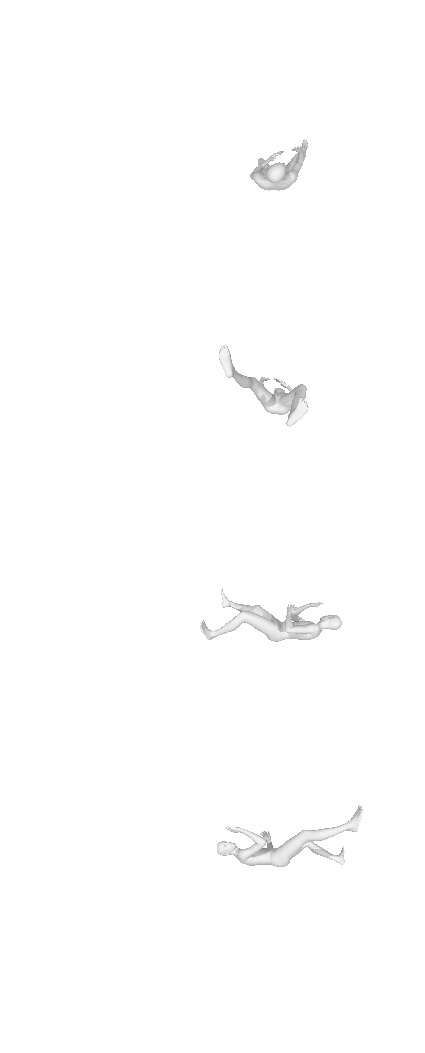

In [38]:
img = imagearray2file(images)
show_image(np.array(img)[0])

<h2>3D data</h2>

Human related 3D data is already covered by SMPL parameters provided along sequence metadata. Garment 3D data is stored as:
<ul>
    <li><b>.OBJ file:</b> widely used in the 3D industry. Mainly for storing mesh faces and UV map.</li>
    <li><b>.PC16 file:</b> animation data. A modification of the common PC2 format where floats are stored as 16-bits instead of 32-bits. Provides mesh vertex locations for each frame. NOTE: this format losses precision for large absolute values, for this reason, vertex location is relative to SMPL root joint.</li>
</ul>

<h3>How to read data?</h3>

DataReader contains high-level functions to avoid dealing with data files directly. For lower-level control, competitors can use I/O functions for these file formats, at 'StarterKit/DataReader/IO.py'.
<br>NOTE: DataReader will automatically apply 'trans' and 'zrot' to vertex locations, the competitors will require to apply them themselves when reading directly from data files.

In [39]:
printer = PrettyPrinter(indent=4)

data_dict = {}
for key in bdata.keys():
    data_dict[key] = c2c(bdata[key])
data_dict['vertices'] = np.array(orig_body_mesh.vertices)
data_dict['faces'] = np.array(orig_body_mesh.faces)

printer.pprint(data_dict)

{   'betas': array([[-0.9579097 ,  2.0335035 , -2.9625165 ,  1.7199788 , -1.260851  ,
         2.7524538 ,  0.85847783,  1.8954473 , -0.84761757, -0.3061962 ]],
      dtype=float32),
    'faces': array([[6325, 2976, 4218],
       [4218, 2976, 4768],
       [2976, 6325, 5060],
       ...,
       [6656, 6392, 6037],
       [6392, 6269, 6037],
       [6037, 6269, 6593]]),
    'frame': array([[29]], dtype=int16),
    'gender': array([[1]], dtype=int16),
    'idx': array([[1103]], dtype=int16),
    'outfit': array([[2, 0, 3, 0, 0, 0]], dtype=int16),
    'pose': array([[ 0.29016417, -1.9519175 , -2.399736  , -0.35034835,  0.09963729,
         0.40542775, -0.45761257, -0.19520192, -0.44924575,  0.3593005 ,
         0.03582402, -0.01594551,  1.0630101 ,  0.1527575 , -0.2538855 ,
         0.4431767 , -0.25295952,  0.14818689,  0.04527666, -0.1448199 ,
         0.11400171, -0.39191258,  0.02409179,  0.0523184 ,  0.38772336,
         0.23887214,  0.27959237, -0.10593657, -0.01889545,  0.0248802 ,

In [40]:
from prepare_data import outfit_types, fabric_types

frame = data_dict['frame'].item() # frame to visualize
sample = "%05d"%(data_dict['idx'].item())

print(f"sample:{sample}, frame:{frame}")

""" Human """
V = data_dict["vertices"]
F = data_dict["faces"]
# Vertex colors (for appealing visualization)
C = np.array([[255,255,255]]*V.shape[0], np.uint8)

""" Garments """
outfit_onehot = data_dict['outfit'] != 0
garments_lst = list(np.nonzero(data_dict['outfit'][0])[0])
garments = [outfit_types[idx] for idx in garments_lst]
print(f"garments: {garments}")
for i,garment in enumerate(garments):
    _V = reader.read_garment_vertices(sample, garment, frame)
    _F = reader.read_garment_topology(sample, garment)
    _F = quads2tris(_F)
    trimesh.Trimesh(vertices=_V, faces=_F).export("cloth.obj")
    # Vertex colors
    _C = np.array([[255*i,0,255*(i-1)]]*_V.shape[0], np.uint8)
    # Merge human and garment meshes into one (for visualization purposes)
    F = np.concatenate((F,_F + V.shape[0]),0)
    V = np.concatenate((V,_V),0)
    C = np.concatenate((C,_C),0)
    trimesh.Trimesh(vertices=np.concatenate((V,C),1), faces=F).export("body.obj")
    del _V
    del _F

""" DISPLAY """
display(V, F, C)

sample:01103, frame:29
garments: ['Top', 'Trousers']


In [14]:
garments_lst

[array([5])]

<h2>Mesh color data</h2>

<h3>UV Mapping</h3>

During rendering, color is assigned to meshes through standard texture UV mapping. Explanation of the underlying mechanism of rendering a textured mesh is outside the scope of this notebook. We assume that competitors participating in Track 3 (texture recovering) have knowledge about this topic.<br>
NOTE: some graphic engines invert UV map vertical coordinate during the transformation to pixel space. Blender's graphic engines work like this. For an example on how UV to pixel mapping is performed, we refer to 'StaterKit/DataReader/util.py', function 'uv_to_pixel', at the end of the file.

<h3>Vertex Color</h3>

Alternatively, meshes can be colored by assigning a color to each vertex. This aproach depends directly on mesh topology and has limited capacity to display texture details. Nevertheless, we believe it is a valid approach and a good entry point for competitors that are not experts on the topic but still want to compete in Track 3.

We provide a functionality to gather the colors of each vertex of a given garment.<br>
NOTE: color is gathered at the EXACT vertex location, so it can be understood as a very coarse approximation of the actual mesh color. Additionally, 'plotly' module (for mesh visualization in this notebook) seems to have problems interpolating vertex colors for sudden changes in intensity (small details). Expect misbehaviours for some samples.

In [4]:
# Read garment vertices and faces again
garment = choice(garments)
V = reader.read_garment_vertices(sample, garment, frame)
F = reader.read_garment_topology(sample, garment)
# Read garment vertex colors
Vt, Ft = reader.read_garment_UVMap(sample, garment) # UV map required to estimate vertex color
C = reader.read_garment_vertex_colors(sample, garment, F, Vt, Ft)
if C.ndim == 1: C = np.stack([C]*V.shape[0], 0) # Plain RGB color
F = quads2tris(F)

""" DISPLAY """
display(V, F, C)

<h2>RGBA data</h2>

In an effort to reduce dataset storage size, we provide RGBA data compressed in videos. Renderings have transparent background to allow competitors to use any background or none at all. As a compromise between data size and reconstruction quality, we compress RGB channels and Alpha channel in different videos. RGB data is compressed with a CRF (Constant Rate Factor) of 18. CRF 18 is well known for producing a "visually lossless" compression. Alpha is compressed with a lossless algorithm, allowing the EXACT reconstruction of this channel.<br>

We want to highlight the main motivation for video compression. To reduce storage size while preserving data integrity. For this reason, competitors must expect non-appealing samples (rough edges) when visualizing RGB videos directly without the corresponding Alpha channel.

<h3>Extracting video frames</h3>

To reconstruct the original frames we provide with a script, at 'StarterKit/DataReader/extract_frames.py'.<br>
Calling the script with no args shall extract the frames of all the samples. Optionally the name of a sample directory can be passed as an arg to extract the frames of this sample alone.<br>
Frames shall be extracted in a subfolder within the sample folder '[SAMPLE]/frames/'.<br>
NOTE: competitors shall change path to data if necessary (line 28).
<h3>Usage</h3>
<br>
<div style="inline:block; color:#555; background-color:#EEE; border:1px solid gray; padding:5px">
    python extract_frames.py<br>
    python extract_frames.py [sample]<br>
</div>
<br>
Again, competitors might reckon using their own I/O functions according to their needs.

<h2>Visualization</h2>

In order to visualize fully textured sequences with their corresponding settings we included a python script for Blender, at 'StarterKit/DataReader/view.py'.

NOTE: Blender's bundled Python might not have <i>pip</i> module installed. For Windows versions >=2.81, <i>pip</i> should be already installed. For other releases, competitors need to run first <i>ensurepip</i> module.

<h3>Usage</h3>
<br>
<div style="inline:block; color:#555; background-color:#EEE; border:1px solid gray; padding:5px">
    blender --python view.py -- [sample]<br>
    blender --python view.py -- [sample] [n.frame]
</div>
<br>
For the sake of simplicity and performance speed, this setup uses Blender's rasterizer engine (EEVEE) instead of its ray tracing engine (CYCLES). Also, PBR materials used on the renderings to simulate realistic fabrics are omitted from this visualization tool. Competitors should expect differences in the way light interacts with objects under this setup w.r.t. to data frames.

<h2>Submission</h2>
<h3>Tracks 1 & 2</h3>
<br>
To minimize connectivty issues competitors around the world might face, we require submissions to be efficiently compressed. To do so, we provide with compress/decompress functionalities at 'StarterKit/DataReader/compress.py'.<br>
Besides data compression, sanity check is performed in the inputs to ensure robustness on the evaluation.
<br>
<h3>Required format</h3>
<ul>
    <li><b>Vertices:</b> NumPy array. $\mathbb{R}^{T\times N\times 3}$, where $T =$ n. of frames and $N =$ n. of vertices.</li>
    <li><b>Faces:</b> NumPy array. Must be triangles. $\mathbb{R}^{N\times 3}$, where $N =$ n. of triangles.</li> 
</ul>
<br>
Note that faces compression is (must be) lossless.

In [5]:
from compress import compress, decompress

V = np.stack([reader.read_garment_vertices(sample, garment, frame_num) for frame_num in range(10)],0)
F = reader.read_garment_topology(sample, garment)
F = quads2tris(F) # Faces MUST be triangles

fname = 'test' # File name must have NO extension
# Compress
compress('test', V, F)
# Decompress
Vr, Fr = decompress('test')

print('Vertex reconstruction error (meters): ', np.abs(V-Vr).mean())
print('Face reconstruction error: ', np.abs(F-Fr).mean())

Vertex reconstruction error (meters):  7.4845804e-05
Face reconstruction error:  0.0


This shall create two files per sample.
<ul>
    <li><b>test.pc16:</b> animation data.</li>
    <li><b>test.bin:</b> mesh topology.</li>
</ul>

<h3>Track 3</h3>

3D + Texture recovery track will be evaluated qualitative. This means the volume of data will be significantly lower in this track and there is no need to apply compression to topology and UV maps, instead, the standard OBJ file format is required.
<br><br>
Each submitted sample shall include:
<ul>
    <li><b>PC16:</b> vertex animation data, same format as Tracks 1 & 2.</li>
    <li><b>OBJ:</b> standard .obj file with mesh topology and UV map. It will be read with the functionality provided at 'StarterKit/DataReader/IO.py'.</li>
    <li><b>PNG:</b> estimated mesh color as texture. Even if competitors work with vertex color, they are required to present their predictions as UV map texturing.
</ul>

<h2>Evaluation</h2>

<br>
In the field of 3D object and point clouds, a common metric is the Chamfer distance.
$$
\begin{equation}
CD(S_1,S_2) = \frac{1}{N_1}\sum_{x\in S_1}min_{y\in S_2}(x - y)^2 + \frac{1}{N_2}\sum_{y\in S_2}min_{x\in S_1}(x - y)^2
\end{equation}
$$
Where $S_1$ and $S_2$ are 3D surfaces (garment GT and prediction), and $N_1$ and $N_2$ are the number of vertices respectively.
Nonetheless, this metric becomes ambiguous when surfaces are close to each other and cannot properly assess surface quality. In order to overcome this, we designed an extension of this idea to surface-to-surface distance.
$$
\begin{equation}
S2S(S_1,S_2)= \frac{1}{N_1}\sum_{x\in S_1}min_{f_y\in S_2}dist(x, f_y) + \frac{1}{N_2}\sum_{y\in S_2}min_{f_x\in S_1}dist(y, f_x)
\end{equation}
$$
Where $x\in S$ are the vertices of surface $S$ and $f\in S$ are the faces (triangles) of $S$, and $dist(x,f)$ is the distance between vertex $x$ and face $f$.
<br><br>
NOTE: This metric requires triangulated meshes.

In [8]:
import pymesh

def surf2surf(V1, F1, V2, F2):
    me1 = pymesh.form_mesh(V1, np.array(F1, np.int32))
    me2 = pymesh.form_mesh(V2, np.array(F2, np.int32))
    return pymesh.distance_to_mesh(me1, me2.vertices)[0].mean() + pymesh.distance_to_mesh(me2, me1.vertices)[0].mean()

# Read garment
V = reader.read_garment_vertices(sample, garment, frame)
F = reader.read_garment_topology(sample, garment)
F = quads2tris(F)
# Add noise to simulate a prediction
V_pred = V + .01*np.random.rand(*V.shape)

# Compute distance
dist = surf2surf(V, F, V_pred, F)
print("Average squared distance: ", dist)

Average squared distance:  7.052959115904416e-05
